# FilmFusion Feature Engineering

This notebook implements comprehensive feature engineering for the recommendation system, including:

1. **Text Features**: TF-IDF vectors from movie overviews
2. **Embedding Features**: Actor/director embeddings using Word2Vec
3. **Metadata Features**: Genre, year, and numerical features
4. **Feature Validation**: Quality checks and analysis



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import logging
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
sys.path.append(os.path.abspath('..'))


In [5]:
from src.feature_engineering.text_features import TextFeatureExtractor
from src.feature_engineering.embedding_features import EmbeddingFeatureExtractor
from config.logging_config import setup_logging

In [6]:
logger = setup_logging()
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [7]:
enriched_dir = Path('../data/enriched')
processed_dir = Path('../data/processed')
features_dir = Path('../data/features')
features_dir.mkdir(exist_ok=True)

In [8]:
try:
    # Load enriched movies data
    enriched_movies = pd.read_csv(enriched_dir / 'movies_enriched.csv')
    print(f" Loaded {len(enriched_movies)} enriched movies")
    
    # Load ratings data
    ratings_df = pd.read_csv(processed_dir / 'ratings_cleaned.csv')
    print(f" Loaded {len(ratings_df)} ratings")
    
    # Display enriched data structure
    print(f"\n ENRICHED DATA STRUCTURE:")
    print(f"Shape: {enriched_movies.shape}")
    print(f"Columns: {list(enriched_movies.columns)}")
    
    # Show sample
    display(enriched_movies.head(3))
    
except FileNotFoundError as e:
    print(f" Data not found: {e}")
    print("Please run the data enrichment script first:")
    print("python scripts/enrich_data_with_tmdb.py")

 Loaded 5922 enriched movies
 Loaded 100836 ratings

 ENRICHED DATA STRUCTURE:
Shape: (5922, 39)
Columns: ['movieId', 'original_title', 'clean_title', 'year', 'genres_original', 'tmdb_id', 'tmdb_title', 'overview', 'tagline', 'genres_tmdb', 'genres_tmdb_ids', 'runtime', 'vote_average', 'vote_count', 'popularity', 'release_date', 'budget', 'revenue', 'status', 'original_language', 'production_companies', 'production_countries', 'spoken_languages', 'cast', 'cast_ids', 'cast_characters', 'directors', 'director_ids', 'producers', 'writers', 'cinematographers', 'composers', 'adult', 'video', 'homepage', 'imdb_id', 'keywords', 'enrichment_date', 'tmdb_api_version']


,movieId,original_title,clean_title,year,genres_original,tmdb_id,tmdb_title,overview,tagline,genres_tmdb,...,writers,cinematographers,composers,adult,video,homepage,imdb_id,keywords,enrichment_date,tmdb_api_version
0,4942,"Angry Red Planet, The (1959)","Angry Red Planet, The",1959.0,Sci-Fi,6974,The Angry Red Planet,The first manned flight to Mars returns after ...,Spectacular Adventure Beyond Time and Space,"['Adventure', 'Science Fiction', 'Horror']",...,"['Sidney W. Pink', 'Sidney W. Pink', 'Ib Melch...",['Stanley Cortez'],['Paul Dunlap'],False,False,NaN,tt0052564,"['spacecraft', 'monster', 'planet mars', 'gian...",2025-07-29T20:22:08.213337,3
1,4945,"Enforcer, The (1976)","Enforcer, The",1976.0,Crime,10649,The Enforcer,"Dirty Harry Callahan returns again, this time ...",The dirtiest Harry of them all.,"['Crime', 'Action']",...,"['Stirling Silliphant', 'Dean Riesner', 'Gail ...",['Charles W. Short'],['Jerry Fielding'],False,False,NaN,tt0074483,"['san francisco, california', 'alcatraz prison...",2025-07-29T20:22:09.169612,3
2,4946,"Eye for an Eye, An (1981)","Eye for an Eye, An",1981.0,Action|Crime|Thriller,42566,An Eye for an Eye,Sean Kane is forced to resign from the San Fra...,Kane's justice is revenge. Kane's weapon is hi...,"['Adventure', 'Action', 'Crime']",...,"['William Gray', 'James Bruner', 'James Bruner']",['Roger Shearman Jr.'],['William Goldstein'],False,False,NaN,tt0082350,"['martial arts', 'police', 'undercover', 'chas...",2025-07-29T20:22:09.932451,3


In [9]:
print(" DATA QUALITY FOR FEATURE ENGINEERING")
print("=" * 50)

# Check availability of key features
feature_availability = {
    'overview': (enriched_movies['overview'].notna() & (enriched_movies['overview'] != '')).sum(),
    'cast': (enriched_movies['cast'].notna() & (enriched_movies['cast'] != '[]')).sum(),
    'directors': (enriched_movies['directors'].notna() & (enriched_movies['directors'] != '[]')).sum(),
    'genres_tmdb': (enriched_movies['genres_tmdb'].notna() & (enriched_movies['genres_tmdb'] != '[]')).sum(),
    'vote_average': enriched_movies['vote_average'].notna().sum(),
    'runtime': enriched_movies['runtime'].notna().sum(),
    'budget': (enriched_movies['budget'] > 0).sum(),
    'revenue': (enriched_movies['revenue'] > 0).sum()
}

print("Feature Availability:")
for feature, count in feature_availability.items():
    percentage = (count / len(enriched_movies)) * 100
    print(f"  {feature}: {count:,} ({percentage:.1f}%)")

 DATA QUALITY FOR FEATURE ENGINEERING
Feature Availability:
  overview: 5,918 (99.9%)
  cast: 5,877 (99.2%)
  directors: 5,907 (99.7%)
  genres_tmdb: 5,910 (99.8%)
  vote_average: 5,922 (100.0%)
  runtime: 5,922 (100.0%)
  budget: 3,573 (60.3%)
  revenue: 3,854 (65.1%)


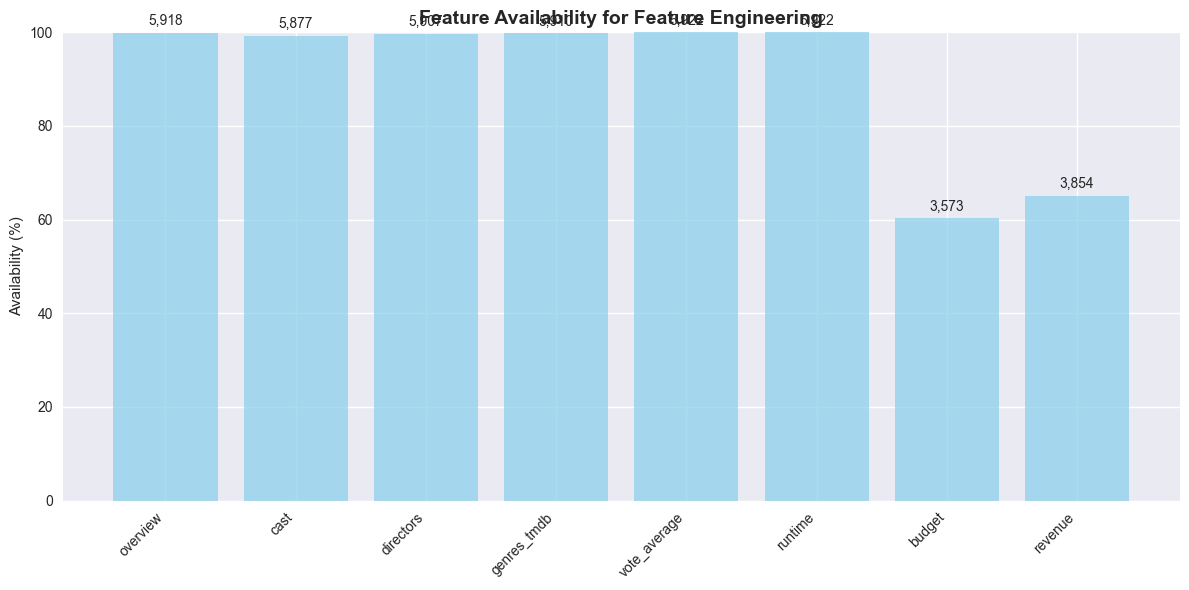


 TEXT FEATURE QUALITY:
  Overview length stats: mean=278, median=249, min=38, max=994

 SAMPLE OVERVIEWS:

1. The Angry Red Planet (1959.0):
   The first manned flight to Mars returns after having been out of communications since it had arrived on Mars. What would it reveal?...

2. The Enforcer (1976.0):
   Dirty Harry Callahan returns again, this time saddled with a rookie female partner. Together, they must stop a terrorist group consisting of angry Vietnam veterans....

3. An Eye for an Eye (1981.0):
   Sean Kane is forced to resign from the San Francisco Police Department's Narcotics Division when he goes berserk after his partner is murdered. He decides to fight alone and follows a trail of drug tr...


In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
features = list(feature_availability.keys())
counts = list(feature_availability.values())
percentages = [c/len(enriched_movies)*100 for c in counts]

bars = ax.bar(features, percentages, color='skyblue', alpha=0.7)
ax.set_title('Feature Availability for Feature Engineering', fontsize=14, fontweight='bold')
ax.set_ylabel('Availability (%)')
ax.set_ylim(0, 100)

# Add value labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
           f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Check text quality
print(f"\n TEXT FEATURE QUALITY:")
valid_overviews = enriched_movies[enriched_movies['overview'].notna() & (enriched_movies['overview'] != '')]
if len(valid_overviews) > 0:
    overview_lengths = valid_overviews['overview'].str.len()
    print(f"  Overview length stats: mean={overview_lengths.mean():.0f}, "
          f"median={overview_lengths.median():.0f}, "
          f"min={overview_lengths.min()}, max={overview_lengths.max()}")
    
    # Show sample overviews
    print(f"\n SAMPLE OVERVIEWS:")
    for i, (_, row) in enumerate(valid_overviews.head(3).iterrows()):
        print(f"\n{i+1}. {row['tmdb_title']} ({row['year']}):")
        print(f"   {row['overview'][:200]}...")

In [12]:
# Download required NLTK data
import nltk
import ssl

# Handle SSL certificate issues (common on Windows)
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download required NLTK resources
print(" Downloading required NLTK data...")
try:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)  # Additional dependency
    print(" NLTK data downloaded successfully!")
except Exception as e:
    print(f" NLTK download issue: {e}")
    print("Trying alternative download method...")
    
    # Alternative download method
    nltk_downloads = ['punkt', 'punkt_tab', 'stopwords', 'wordnet', 'omw-1.4']
    for item in nltk_downloads:
        try:
            nltk.download(item, quiet=True)
            print(f" Downloaded {item}")
        except:
            print(f" Failed to download {item}")


 NLTK data downloaded successfully!


 EXTRACTING TEXT FEATURES (TF-IDF)
Movies with overview: 5918
2025-07-29 22:09:53,183 - src.feature_engineering.text_features - INFO - Extracting TF-IDF features from movie overviews...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sarva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sarva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sarva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


2025-07-29 22:10:03,027 - src.feature_engineering.text_features - INFO - Created TF-IDF matrix: (5918, 5000)
2025-07-29 22:10:03,027 - src.feature_engineering.text_features - INFO - Top features: ['aaron', 'abandon', 'abandoned', 'abducted', 'ability', 'able', 'aboard', 'abroad', 'abrupt', 'absence']
 TF-IDF matrix shape: (5918, 5000)
 Number of features: 5000

 TOP 20 TF-IDF FEATURES:


,feature,total_score
2567,life,123.551505
4978,young,85.816718
3019,new,85.136367
4935,world,80.724835
1611,family,76.061274
2728,man,74.314844
1805,friend,72.901580
4916,woman,69.639451
4963,year,64.534881
4249,story,64.108662


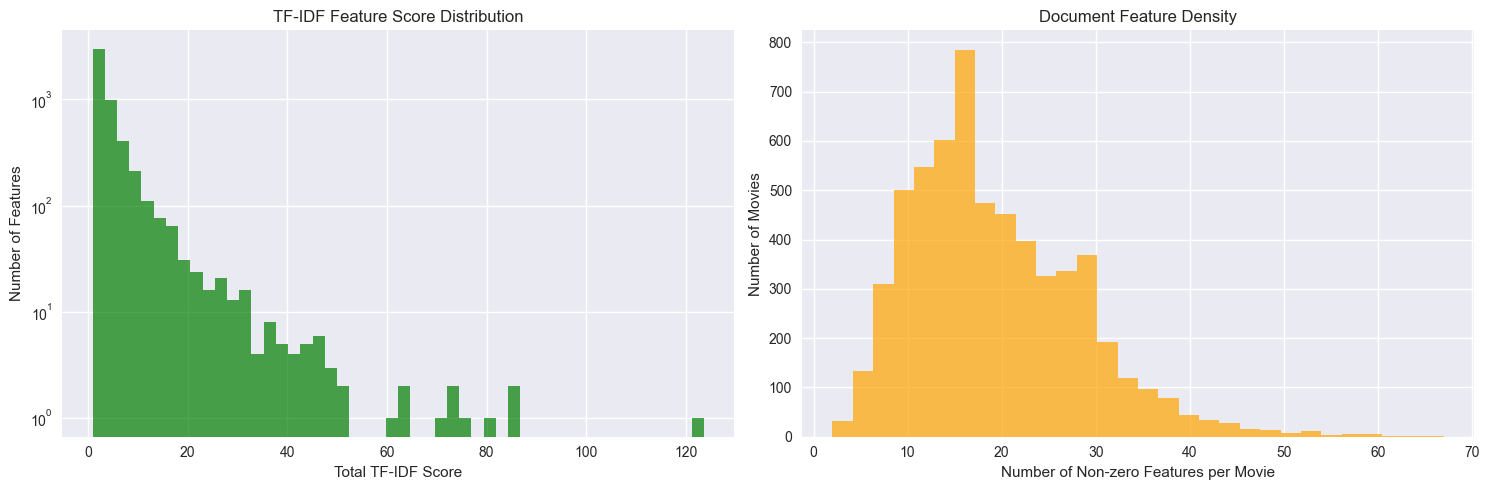

 Saving TF-IDF features...
2025-07-29 22:10:04,018 - src.feature_engineering.text_features - INFO - TF-IDF vectorizer saved to ..\data\features\tfidf_vectorizer.pkl
 TF-IDF features saved to data/features/


In [13]:
# Extract TF-IDF features from movie overviews
print(" EXTRACTING TEXT FEATURES (TF-IDF)")
print("=" * 40)

# Initialize text feature extractor
text_extractor = TextFeatureExtractor(
    max_features=5000,  # Top 5000 features
    min_df=2,          # Minimum document frequency
    max_df=0.8         # Maximum document frequency
)

# Filter movies with valid overviews
movies_with_overview = enriched_movies[
    enriched_movies['overview'].notna() & (enriched_movies['overview'] != '')
].copy()

print(f"Movies with overview: {len(movies_with_overview)}")

if len(movies_with_overview) > 0:
    # Extract TF-IDF features
    tfidf_matrix, feature_names = text_extractor.fit_transform(movies_with_overview)
    
    print(f" TF-IDF matrix shape: {tfidf_matrix.shape}")
    print(f" Number of features: {len(feature_names)}")
    
    # Analyze feature importance
    feature_scores = np.array(tfidf_matrix.sum(axis=0)).flatten()
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'total_score': feature_scores
    }).sort_values('total_score', ascending=False)
    
    print(f"\n TOP 20 TF-IDF FEATURES:")
    display(feature_importance.head(20))
     # Visualize feature distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Feature importance distribution
    axes[0].hist(feature_scores, bins=50, alpha=0.7, color='green')
    axes[0].set_title('TF-IDF Feature Score Distribution')
    axes[0].set_xlabel('Total TF-IDF Score')
    axes[0].set_ylabel('Number of Features')
    axes[0].set_yscale('log')
    
    # Document sparsity
    doc_sparsity = (tfidf_matrix != 0).sum(axis=1).A1
    axes[1].hist(doc_sparsity, bins=30, alpha=0.7, color='orange')
    axes[1].set_title('Document Feature Density')
    axes[1].set_xlabel('Number of Non-zero Features per Movie')
    axes[1].set_ylabel('Number of Movies')
    
    plt.tight_layout()
    plt.show()
    
    # Save TF-IDF features
    print(" Saving TF-IDF features...")
    
    # Save sparse matrix
    from scipy import sparse
    sparse.save_npz(features_dir / 'tfidf_matrix.npz', tfidf_matrix)
    
    # Save feature names
    with open(features_dir / 'tfidf_feature_names.json', 'w') as f:
        json.dump(feature_names.tolist(), f)
    
    # Save movie mapping
    tfidf_movie_mapping = movies_with_overview[['movieId', 'tmdb_title']].reset_index()
    tfidf_movie_mapping.to_csv(features_dir / 'tfidf_movie_mapping.csv', index=False)
    
    # Save vectorizer
    text_extractor.save_vectorizer(features_dir / 'tfidf_vectorizer.pkl')
    
    print(" TF-IDF features saved to data/features/")
    
else:
    print("  No movies with overviews found for TF-IDF extraction")
    tfidf_matrix = None

In [14]:
# Extract embedding features for actors and directors
print(" EXTRACTING EMBEDDING FEATURES")
print("=" * 40)

# Initialize embedding extractor
embedding_extractor = EmbeddingFeatureExtractor(
    embedding_dim=100,
    min_count=2
)

# Train embeddings
embedding_extractor.train_embeddings(enriched_movies)

# Get movie embeddings
movie_embeddings = embedding_extractor.get_movie_embeddings(enriched_movies)
print(f" Movie embeddings shape: {movie_embeddings.shape}")

# Create categorical features
categorical_features = embedding_extractor.create_categorical_features(enriched_movies)

print(f"\n CATEGORICAL FEATURES:")
for feature_name, feature_matrix in categorical_features.items():
    print(f"  {feature_name}: {feature_matrix.shape}")

# Analyze actor embeddings
if embedding_extractor.actor_w2v:
    print(f"\n ACTOR EMBEDDING ANALYSIS:")
    print(f"  Vocabulary size: {len(embedding_extractor.actor_w2v.wv)}")
    
    # Find similar actors (examples)
    try:
        sample_actors = ['Tom Hanks', 'Robert De Niro', 'Meryl Streep', 'Leonardo DiCaprio']
        for actor in sample_actors:
            if actor in embedding_extractor.actor_w2v.wv:
                similar_actors = embedding_extractor.actor_w2v.wv.most_similar(actor, topn=5)
                print(f"  Similar to {actor}: {[a[0] for a in similar_actors]}")
                break
    except:
        print("  Could not compute actor similarities")

 EXTRACTING EMBEDDING FEATURES
2025-07-29 22:10:45,609 - src.feature_engineering.embedding_features - INFO - Training actor and director embeddings...
2025-07-29 22:10:46,635 - gensim.models.word2vec - INFO - collecting all words and their counts
2025-07-29 22:10:46,636 - gensim.models.word2vec - INFO - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-07-29 22:10:46,669 - gensim.models.word2vec - INFO - collected 28080 word types from a corpus of 56065 raw words and 5877 sentences
2025-07-29 22:10:46,671 - gensim.models.word2vec - INFO - Creating a fresh vocabulary
2025-07-29 22:10:46,729 - gensim.utils - INFO - Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 8197 unique words (29.19% of original 28080, drops 19883)', 'datetime': '2025-07-29T22:10:46.729748', 'gensim': '4.3.3', 'python': '3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}



 DIRECTOR EMBEDDING ANALYSIS:
  Vocabulary size: 3565


Text(0, 0.5, 'Number of Movies')

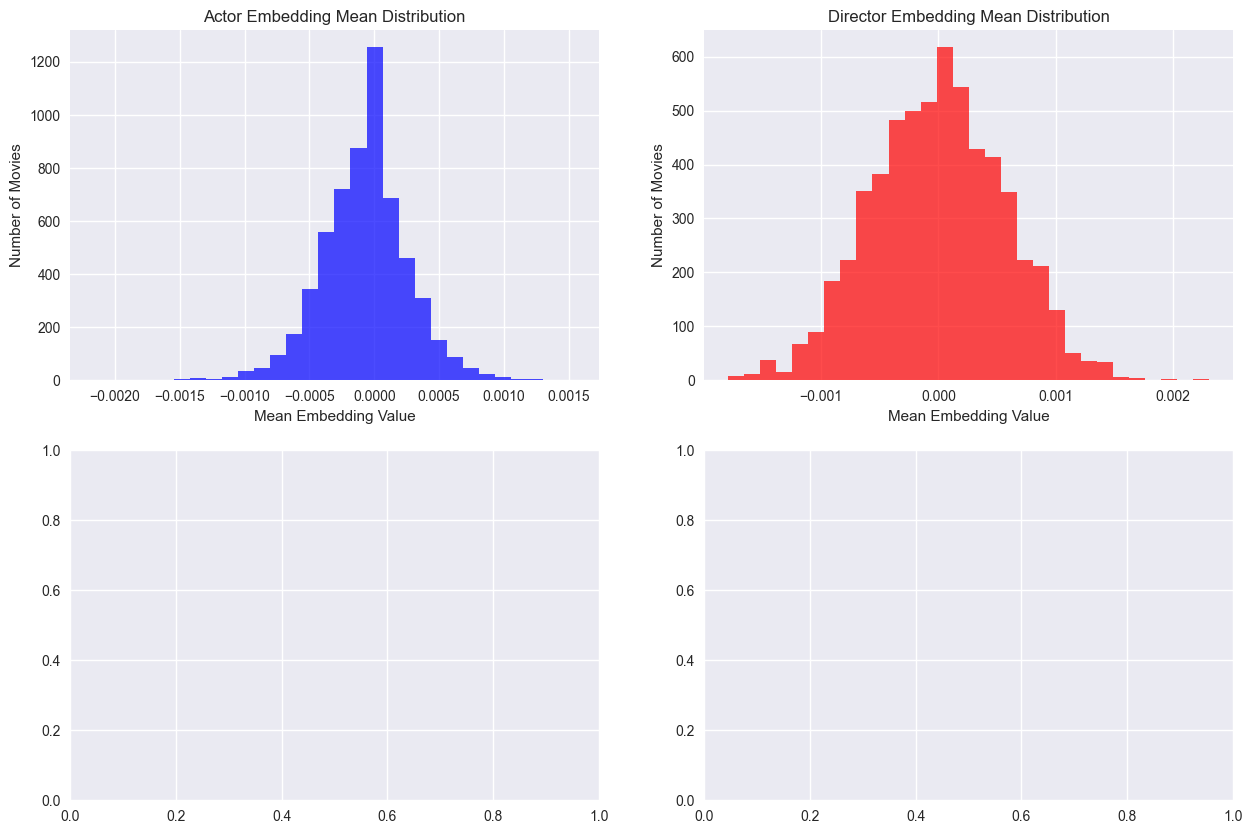

In [15]:
# Analyze director embeddings
if embedding_extractor.director_w2v:
    print(f"\n DIRECTOR EMBEDDING ANALYSIS:")
    print(f"  Vocabulary size: {len(embedding_extractor.director_w2v.wv)}")

# Visualize embedding distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Actor embedding distribution
actor_emb_means = movie_embeddings[:, :100].mean(axis=1)
axes[0, 0].hist(actor_emb_means, bins=30, alpha=0.7, color='blue')
axes[0, 0].set_title('Actor Embedding Mean Distribution')
axes[0, 0].set_xlabel('Mean Embedding Value')
axes[0, 0].set_ylabel('Number of Movies')

# Director embedding distribution
director_emb_means = movie_embeddings[:, 100:].mean(axis=1)
axes[0, 1].hist(director_emb_means, bins=30, alpha=0.7, color='red')
axes[0, 1].set_title('Director Embedding Mean Distribution')
axes[0, 1].set_xlabel('Mean Embedding Value')
axes[0, 1].set_ylabel('Number of Movies')

In [16]:
# Genre feature distribution
if 'genres' in categorical_features:
    genre_counts = categorical_features['genres'].sum(axis=0)
    top_genres_idx = np.argsort(genre_counts)[-15:]  # Top 15 genres
    
    axes[1, 0].bar(range(len(top_genres_idx)), genre_counts[top_genres_idx])
    axes[1, 0].set_title('Top 15 Genre Frequencies')
    axes[1, 0].set_xlabel('Genre Index')
    axes[1, 0].set_ylabel('Frequency')

# Embedding feature correlation
embedding_corr = np.corrcoef(movie_embeddings.T)
im = axes[1, 1].imshow(embedding_corr, cmap='coolwarm', aspect='auto')
axes[1, 1].set_title('Embedding Feature Correlation')
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()


<Figure size 800x550 with 0 Axes>

In [17]:
# Save embedding features
print(" Saving embedding features...")

# Save movie embeddings
np.save(features_dir / 'movie_embeddings.npy', movie_embeddings)

# Save categorical features
for feature_name, feature_matrix in categorical_features.items():
    np.save(features_dir / f'{feature_name}_features.npy', feature_matrix)

# Save embeddings and encoders
embedding_extractor.save_embeddings(str(features_dir / 'embeddings'))

print(" Embedding features saved to data/features/")

 Saving embedding features...
2025-07-29 22:11:52,260 - gensim.utils - INFO - Word2Vec lifecycle event {'fname_or_handle': '..\\data\\features\\embeddings_actor_w2v.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-07-29T22:11:52.260315', 'gensim': '4.3.3', 'python': '3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'saving'}
2025-07-29 22:11:52,262 - gensim.utils - INFO - not storing attribute cum_table
2025-07-29 22:11:52,277 - gensim.utils - INFO - saved ..\data\features\embeddings_actor_w2v.model
2025-07-29 22:11:52,279 - gensim.utils - INFO - Word2Vec lifecycle event {'fname_or_handle': '..\\data\\features\\embeddings_director_w2v.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-07-29T22:11:52.278872', 'gensim': '4.3.3', 'python': '3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MS

 EXTRACTING METADATA FEATURES
 Numerical features shape: (5922, 7)
Features: ['Vote Average', 'Log Vote Count', 'Log Popularity', 'Runtime', 'Log Budget', 'Log Revenue', 'Release Year']


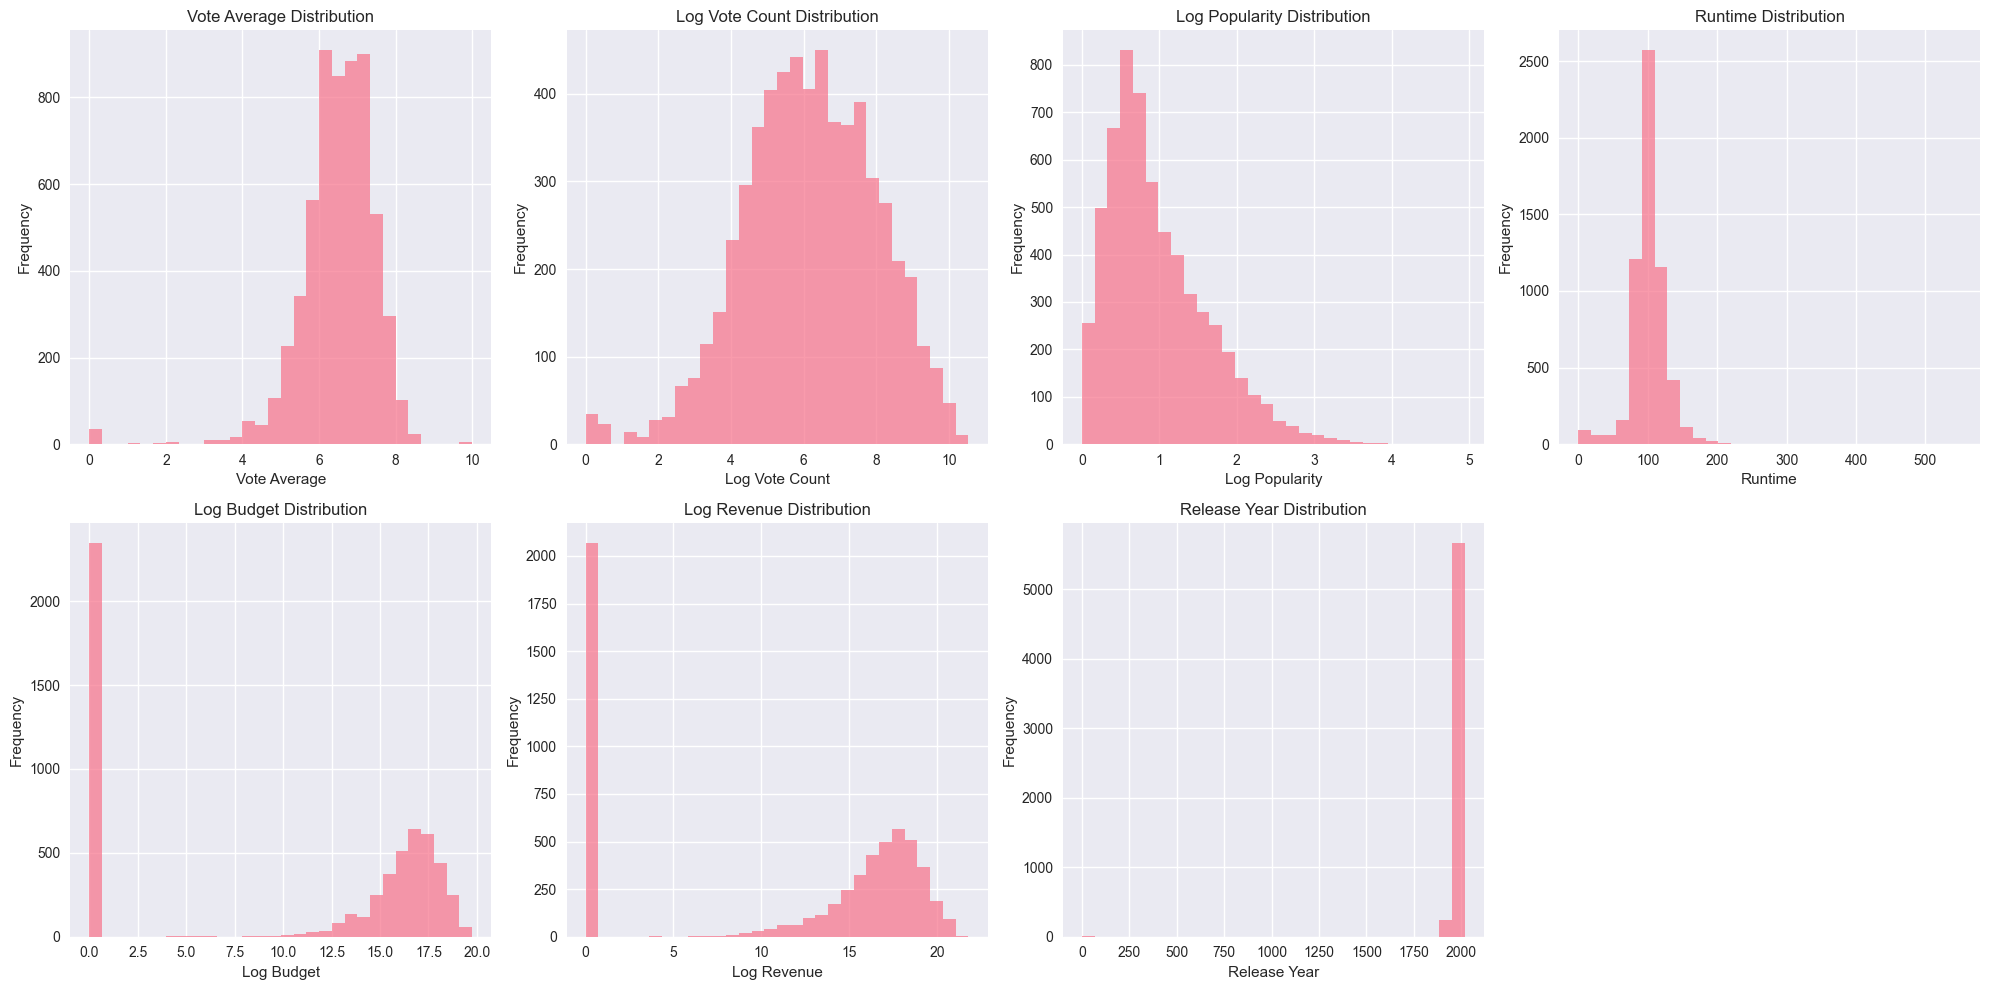

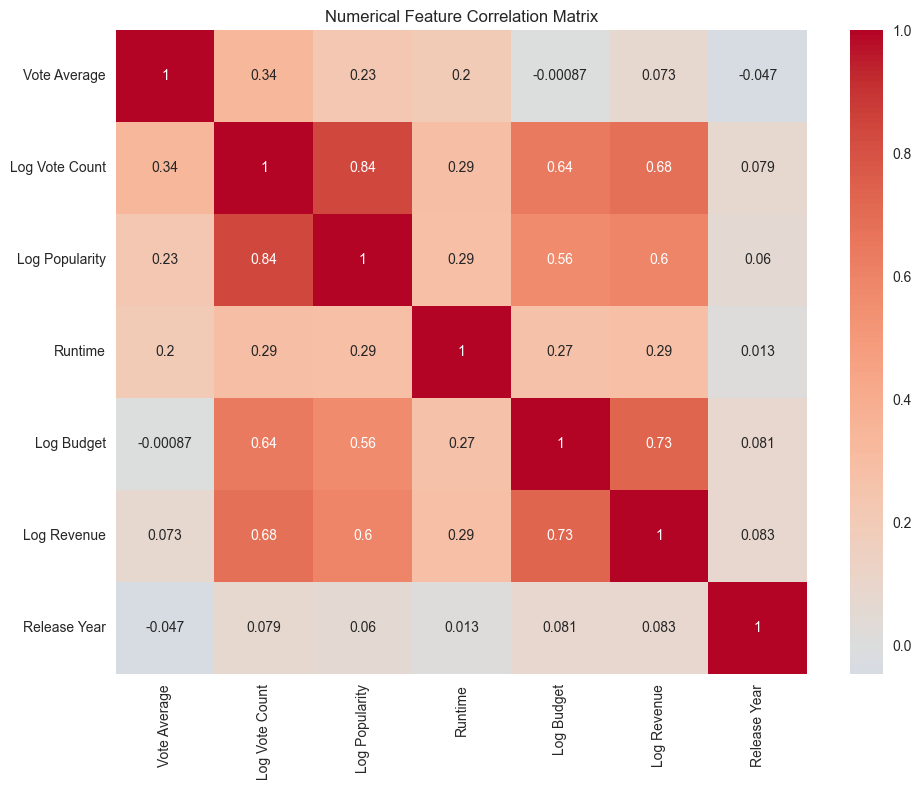

 Numerical features saved


In [18]:
# Extract metadata features
print(" EXTRACTING METADATA FEATURES")
print("=" * 40)

# Numerical features
numerical_features = []
numerical_feature_names = []

feature_configs = [
    ('vote_average', 'Vote Average'),
    ('vote_count', 'Vote Count'),
    ('popularity', 'Popularity'),
    ('runtime', 'Runtime'),
    ('budget', 'Budget'),
    ('revenue', 'Revenue'),
    ('year', 'Release Year')
]

metadata_df = enriched_movies.copy()

for col, name in feature_configs:
    if col in metadata_df.columns:
        # Fill missing values and handle outliers
        feature_data = metadata_df[col].fillna(0)
        
        # Log transform for skewed features
        if col in ['budget', 'revenue', 'vote_count', 'popularity']:
            feature_data = np.log1p(feature_data)  # log(1 + x)
            name = f"Log {name}"
        
        numerical_features.append(feature_data.values)
        numerical_feature_names.append(name)

# Stack numerical features
if numerical_features:
    numerical_matrix = np.column_stack(numerical_features)
    
    # Standardize features
    scaler = StandardScaler()
    numerical_matrix_scaled = scaler.fit_transform(numerical_matrix)
    
    print(f" Numerical features shape: {numerical_matrix_scaled.shape}")
    print(f"Features: {numerical_feature_names}")
    
    # Analyze feature distributions
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, (feature_data, name) in enumerate(zip(numerical_features, numerical_feature_names)):
        if i < len(axes):
            axes[i].hist(feature_data, bins=30, alpha=0.7)
            axes[i].set_title(f'{name} Distribution')
            axes[i].set_xlabel(name)
            axes[i].set_ylabel('Frequency')
    
    # Remove empty subplots
    for i in range(len(numerical_feature_names), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()
    
    # Feature correlation analysis
    feature_corr = np.corrcoef(numerical_matrix_scaled.T)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(feature_corr, 
                xticklabels=numerical_feature_names,
                yticklabels=numerical_feature_names,
                annot=True, cmap='coolwarm', center=0)
    plt.title('Numerical Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Save numerical features
    np.save(features_dir / 'numerical_features.npy', numerical_matrix_scaled)
    with open(features_dir / 'numerical_feature_names.json', 'w') as f:
        json.dump(numerical_feature_names, f)
    
    # Save scaler
    with open(features_dir / 'numerical_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    
    print(" Numerical features saved")

else:
    print("  No numerical features available")
    numerical_matrix_scaled = None

In [20]:
# Integrate all features and create master feature matrix
print(" FEATURE INTEGRATION")
print("=" * 30)

# Create feature integration mapping with proper error handling
feature_summary = {
    'movie_count': len(enriched_movies),
    'features': {}
}

# TF-IDF features
if 'tfidf_matrix' in locals() and tfidf_matrix is not None:
    feature_summary['features']['tfidf'] = {
        'available': True,
        'shape': tfidf_matrix.shape,
        'type': 'sparse'
    }
else:
    feature_summary['features']['tfidf'] = {
        'available': False,
        'shape': None,
        'type': 'sparse'
    }

# Embedding features
if 'movie_embeddings' in locals() and movie_embeddings.shape[0] > 0:
    feature_summary['features']['embeddings'] = {
        'available': True,
        'shape': movie_embeddings.shape,
        'type': 'dense'
    }
else:
    feature_summary['features']['embeddings'] = {
        'available': False,
        'shape': None,
        'type': 'dense'
    }

# Categorical features
if 'categorical_features' in locals() and len(categorical_features) > 0:
    feature_summary['features']['categorical'] = {
        'available': True,
        'shape': {name: matrix.shape for name, matrix in categorical_features.items()},
        'type': 'dense'
    }
else:
    feature_summary['features']['categorical'] = {
        'available': False,
        'shape': None,
        'type': 'dense'
    }

# Numerical features
if 'numerical_matrix_scaled' in locals() and numerical_matrix_scaled is not None:
    feature_summary['features']['numerical'] = {
        'available': True,
        'shape': numerical_matrix_scaled.shape,
        'type': 'dense'
    }
else:
    feature_summary['features']['numerical'] = {
        'available': False,
        'shape': None,
        'type': 'dense'
    }

print(" FEATURE INTEGRATION SUMMARY:")
for feature_type, info in feature_summary['features'].items():
    if info['available']:
        if feature_type == 'categorical' and isinstance(info['shape'], dict):
            print(f" {feature_type.upper()}: {info['type']}")
            for sub_feature, shape in info['shape'].items():
                print(f"   - {sub_feature}: {shape}")
        else:
            print(f" {feature_type.upper()}: {info['shape']} ({info['type']})")
    else:
        print(f" {feature_type.upper()}: Not available")

# Create movie feature mapping
movie_feature_mapping = enriched_movies[['movieId', 'tmdb_title', 'year']].copy()

# Check TF-IDF availability
if 'movies_with_overview' in locals() and len(movies_with_overview) > 0:
    movie_feature_mapping['has_tfidf'] = movie_feature_mapping['movieId'].isin(
        movies_with_overview['movieId']
    )
else:
    movie_feature_mapping['has_tfidf'] = False

# All movies have some form of embeddings and metadata (even if zero-filled)
movie_feature_mapping['has_embeddings'] = True
movie_feature_mapping['has_metadata'] = True

print(f"\n FEATURE COVERAGE:")
print(f"Movies with TF-IDF features: {movie_feature_mapping['has_tfidf'].sum()}")
print(f"Movies with embeddings: {movie_feature_mapping['has_embeddings'].sum()}")
print(f"Movies with metadata: {movie_feature_mapping['has_metadata'].sum()}")

# Check which features were successfully created
created_features = []
if feature_summary['features']['tfidf']['available']:
    created_features.append('TF-IDF')
if feature_summary['features']['embeddings']['available']:
    created_features.append('Embeddings')
if feature_summary['features']['categorical']['available']:
    created_features.append('Categorical')
if feature_summary['features']['numerical']['available']:
    created_features.append('Numerical')

print(f"\n Successfully created features: {', '.join(created_features)}")

# Save feature integration summary
try:
    with open(features_dir / 'feature_summary.json', 'w') as f:
        json.dump(feature_summary, f, indent=2, default=str)
    
    movie_feature_mapping.to_csv(features_dir / 'movie_feature_mapping.csv', index=False)
    print(" Feature integration summary saved")
    
except Exception as e:
    print(f"  Warning: Could not save feature summary: {e}")

print(" Feature integration completed")


 FEATURE INTEGRATION
 FEATURE INTEGRATION SUMMARY:
 TFIDF: (5918, 5000) (sparse)
 EMBEDDINGS: (5922, 200) (dense)
 CATEGORICAL: dense
   - genres: (5922, 19)
 NUMERICAL: (5922, 7) (dense)

 FEATURE COVERAGE:
Movies with TF-IDF features: 5918
Movies with embeddings: 5922
Movies with metadata: 5922

 Successfully created features: TF-IDF, Embeddings, Categorical, Numerical
 Feature integration summary saved
 Feature integration completed


In [22]:
# Validate feature quality and completeness
print(" FEATURE QUALITY VALIDATION")
print("=" * 35)

validation_results = {}

# 1. TF-IDF Validation
if 'tfidf_matrix' in locals() and tfidf_matrix is not None:
    tfidf_stats = {
        'shape': tfidf_matrix.shape,
        'sparsity': 1 - (tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])),
        'avg_features_per_doc': tfidf_matrix.nnz / tfidf_matrix.shape[0],
        'max_feature_value': float(tfidf_matrix.max()),
        'min_feature_value': float(tfidf_matrix.min())
    }
    validation_results['tfidf'] = tfidf_stats
    
    print(f"TF-IDF Validation:")
    print(f"  Sparsity: {tfidf_stats['sparsity']:.3f}")
    print(f"  Avg features per document: {tfidf_stats['avg_features_per_doc']:.1f}")
    print(f"  Value range: {tfidf_stats['min_feature_value']:.3f} - {tfidf_stats['max_feature_value']:.3f}")

# 2. Embedding Validation
if 'movie_embeddings' in locals() and movie_embeddings.size > 0:
    embedding_stats = {
        'shape': movie_embeddings.shape,
        'mean': float(movie_embeddings.mean()),
        'std': float(movie_embeddings.std()),
        'zero_embeddings': int((movie_embeddings.sum(axis=1) == 0).sum()),
        'nan_count': int(np.isnan(movie_embeddings).sum())
    }
    validation_results['embeddings'] = embedding_stats
    
    print(f"\nEmbedding Validation:")
    print(f"  Mean: {embedding_stats['mean']:.3f}")
    print(f"  Std: {embedding_stats['std']:.3f}")
    print(f"  Zero embeddings: {embedding_stats['zero_embeddings']}")
    print(f"  NaN values: {embedding_stats['nan_count']}")

# 3. Numerical Feature Validation
if 'numerical_matrix_scaled' in locals() and numerical_matrix_scaled is not None:
    numerical_stats = {
        'shape': numerical_matrix_scaled.shape,
        'mean': float(numerical_matrix_scaled.mean()),
        'std': float(numerical_matrix_scaled.std()),
        'nan_count': int(np.isnan(numerical_matrix_scaled).sum()),
        'inf_count': int(np.isinf(numerical_matrix_scaled).sum())
    }
    validation_results['numerical'] = numerical_stats
    
    print(f"\nNumerical Feature Validation:")
    print(f"  Mean: {numerical_stats['mean']:.3f}")
    print(f"  Std: {numerical_stats['std']:.3f}")
    print(f"  NaN values: {numerical_stats['nan_count']}")
    print(f"  Inf values: {numerical_stats['inf_count']}")

# 4. Categorical Feature Validation
if 'categorical_features' in locals() and len(categorical_features) > 0:
    categorical_stats = {}
    for feature_name, feature_matrix in categorical_features.items():
        categorical_stats[feature_name] = {
            'shape': feature_matrix.shape,
            'sparsity': 1 - (np.count_nonzero(feature_matrix) / feature_matrix.size),
            'active_features_per_item': np.mean(np.sum(feature_matrix, axis=1))
        }
    
    validation_results['categorical'] = categorical_stats
    
    print(f"\nCategorical Feature Validation:")
    for feature_name, stats in categorical_stats.items():
        print(f"  {feature_name}:")
        print(f"    Shape: {stats['shape']}")
        print(f"    Sparsity: {stats['sparsity']:.3f}")
        print(f"    Avg active features per item: {stats['active_features_per_item']:.1f}")

# 5. Coverage Analysis (Fixed)
coverage_analysis = {
    'total_movies': len(enriched_movies),
    'feature_coverage': {}
}

# Calculate feature coverage with proper shape handling
feature_counts = {}

# TF-IDF coverage
if 'tfidf_matrix' in locals() and tfidf_matrix is not None:
    feature_counts['tfidf'] = tfidf_matrix.shape[0]
else:
    feature_counts['tfidf'] = 0

# Embedding coverage
if 'movie_embeddings' in locals() and movie_embeddings.size > 0:
    feature_counts['embeddings'] = movie_embeddings.shape[0]
else:
    feature_counts['embeddings'] = 0

# Categorical coverage
if 'categorical_features' in locals() and len(categorical_features) > 0:
    # Take the first categorical feature's row count as representative
    first_feature = next(iter(categorical_features.values()))
    feature_counts['categorical'] = first_feature.shape[0]
else:
    feature_counts['categorical'] = 0

# Numerical coverage
if 'numerical_matrix_scaled' in locals() and numerical_matrix_scaled is not None:
    feature_counts['numerical'] = numerical_matrix_scaled.shape[0]
else:
    feature_counts['numerical'] = 0

# Calculate percentages
for feature_type, count in feature_counts.items():
    coverage_analysis['feature_coverage'][feature_type] = {
        'count': count,
        'percentage': (count / len(enriched_movies) * 100) if len(enriched_movies) > 0 else 0
    }

validation_results['coverage'] = coverage_analysis

print(f"\n COVERAGE ANALYSIS:")
for feature_type, coverage in coverage_analysis['feature_coverage'].items():
    print(f"  {feature_type}: {coverage['count']} movies ({coverage['percentage']:.1f}%)")

# 6. Overall Quality Score
quality_scores = []
if 'tfidf' in validation_results:
    # TF-IDF quality: lower sparsity is better
    tfidf_quality = 1 - validation_results['tfidf']['sparsity']
    quality_scores.append(('tfidf', tfidf_quality))

if 'embeddings' in validation_results:
    # Embedding quality: fewer zero embeddings is better
    total_embeddings = validation_results['embeddings']['shape'][0]
    zero_embeddings = validation_results['embeddings']['zero_embeddings']
    embedding_quality = 1 - (zero_embeddings / total_embeddings) if total_embeddings > 0 else 0
    quality_scores.append(('embeddings', embedding_quality))

if 'numerical' in validation_results:
    # Numerical quality: no NaN/Inf values is perfect
    numerical_quality = 1.0 if (validation_results['numerical']['nan_count'] == 0 and 
                               validation_results['numerical']['inf_count'] == 0) else 0.8
    quality_scores.append(('numerical', numerical_quality))

if quality_scores:
    overall_quality = np.mean([score for _, score in quality_scores])
    validation_results['overall_quality'] = {
        'score': float(overall_quality),
        'grade': 'Excellent' if overall_quality >= 0.9 else 
                'Good' if overall_quality >= 0.7 else 
                'Fair' if overall_quality >= 0.5 else 'Poor',
        'component_scores': dict(quality_scores)
    }
    
    print(f"\n OVERALL QUALITY ASSESSMENT:")
    print(f"  Quality Score: {overall_quality:.3f}")
    print(f"  Grade: {validation_results['overall_quality']['grade']}")
    
    if quality_scores:
        print(f"  Component Scores:")
        for component, score in quality_scores:
            print(f"    {component}: {score:.3f}")

# Save validation results
try:
    with open(features_dir / 'feature_validation.json', 'w') as f:
        json.dump(validation_results, f, indent=2, default=str)
    print(f"\n Feature validation completed and saved to {features_dir / 'feature_validation.json'}")
except Exception as e:
    print(f"\n  Warning: Could not save validation results: {e}")
    print(" Feature validation completed (not saved)")

# Display summary
print(f"\n VALIDATION SUMMARY:")
print(f"  Total movies processed: {len(enriched_movies)}")
print(f"  Features validated: {len(validation_results) - 1}")  # -1 for coverage
if 'overall_quality' in validation_results:
    print(f"  Overall quality: {validation_results['overall_quality']['grade']}")


 FEATURE QUALITY VALIDATION
TF-IDF Validation:
  Sparsity: 0.996
  Avg features per document: 19.2
  Value range: 0.000 - 0.936

Embedding Validation:
  Mean: -0.000
  Std: 0.005
  Zero embeddings: 10
  NaN values: 0

Numerical Feature Validation:
  Mean: -0.000
  Std: 1.000
  NaN values: 0
  Inf values: 0

Categorical Feature Validation:
  genres:
    Shape: (5922, 19)
    Sparsity: 0.867
    Avg active features per item: 2.5

 COVERAGE ANALYSIS:
  tfidf: 5918 movies (99.9%)
  embeddings: 5922 movies (100.0%)
  categorical: 5922 movies (100.0%)
  numerical: 5922 movies (100.0%)

 OVERALL QUALITY ASSESSMENT:
  Quality Score: 0.667
  Grade: Fair
  Component Scores:
    tfidf: 0.004
    embeddings: 0.998
    numerical: 1.000

 Feature validation completed and saved to ..\data\features\feature_validation.json

 VALIDATION SUMMARY:
  Total movies processed: 5922
  Features validated: 5
  Overall quality: Fair


In [23]:
# Demonstrate feature usage for different recommendation approaches
print(" FEATURE USAGE EXAMPLES")
print("=" * 30)

# Example 1: Content-based similarity using TF-IDF
if tfidf_matrix is not None and len(movies_with_overview) > 5:
    print(" CONTENT-BASED SIMILARITY EXAMPLE:")
    
    # Compute similarity for first 5 movies
    sample_tfidf = tfidf_matrix[:5]
    similarity_matrix = cosine_similarity(sample_tfidf)
    
    sample_movies = movies_with_overview.head(5)
    
    print("TF-IDF Similarity Matrix (first 5 movies):")
    similarity_df = pd.DataFrame(
        similarity_matrix,
        index=sample_movies['tmdb_title'].values,
        columns=sample_movies['tmdb_title'].values
    )
    display(similarity_df.round(3))
    
    # Find most similar pair
    max_sim_idx = np.unravel_index(
        np.argmax(similarity_matrix - np.eye(similarity_matrix.shape[0])), 
        similarity_matrix.shape
    )
    
    movie1 = sample_movies.iloc[max_sim_idx[0]]['tmdb_title']
    movie2 = sample_movies.iloc[max_sim_idx[1]]['tmdb_title']
    similarity_score = similarity_matrix[max_sim_idx]
    
    print(f"\nMost similar pair: '{movie1}' and '{movie2}' (similarity: {similarity_score:.3f})")

# Example 2: Actor-based similarity using embeddings
if embedding_extractor.actor_w2v and len(enriched_movies) > 0:
    print(f"\n ACTOR-BASED SIMILARITY EXAMPLE:")
    
    # Find movies with Tom Hanks (if available)
    sample_cast = enriched_movies[enriched_movies['cast'].str.contains('Tom Hanks', na=False)]
    
    if len(sample_cast) > 0:
        print(f"Found {len(sample_cast)} movies with Tom Hanks:")
        for _, row in sample_cast.head(3).iterrows():
            print(f"  - {row['tmdb_title']} ({row['year']})")
    else:
        print("Tom Hanks not found in dataset")

# Example 3: Genre-based filtering
if 'genres' in categorical_features:
    print(f"\n GENRE-BASED FILTERING EXAMPLE:")
    
    genre_matrix = categorical_features['genres']
    genre_encoder = embedding_extractor.genre_encoder
    
    # Find action movies
    try:
        action_idx = list(genre_encoder.classes_).index('Action')
        action_movies = enriched_movies[genre_matrix[:, action_idx] == 1]
        
        print(f"Found {len(action_movies)} Action movies:")
        for _, row in action_movies.head(5).iterrows():
            print(f"  - {row['tmdb_title']} ({row['year']})")
    except (ValueError, AttributeError):
        print("Action genre not found or encoder not available")

print(f"\n FEATURE ENGINEERING COMPLETED!")
print(f"All features saved to: {features_dir}")
print(f"\n Generated Files:")
for file_path in features_dir.glob('*'):
    print(f"  - {file_path.name}")


 FEATURE USAGE EXAMPLES
 CONTENT-BASED SIMILARITY EXAMPLE:
TF-IDF Similarity Matrix (first 5 movies):


,The Angry Red Planet,The Enforcer,An Eye for an Eye,The Gauntlet,Lord of the Flies
The Angry Red Planet,1.000,0.042,0.000,0.0,0.0
The Enforcer,0.042,1.000,0.048,0.0,0.0
An Eye for an Eye,0.000,0.048,1.000,0.0,0.0
The Gauntlet,0.000,0.000,0.000,1.0,0.0
Lord of the Flies,0.000,0.000,0.000,0.0,1.0



Most similar pair: 'The Enforcer' and 'An Eye for an Eye' (similarity: 0.048)

 ACTOR-BASED SIMILARITY EXAMPLE:
Found 24 movies with Tom Hanks:
  - Joe Versus the Volcano (1990.0)
  - Road to Perdition (2002.0)
  - Catch Me If You Can (2002.0)

 GENRE-BASED FILTERING EXAMPLE:
Found 1266 Action movies:
  - The Enforcer (1976.0)
  - An Eye for an Eye (1981.0)
  - The Gauntlet (1977.0)
  - The Stunt Man (1980.0)
  - Sudden Impact (1983.0)

 FEATURE ENGINEERING COMPLETED!
All features saved to: ..\data\features

 Generated Files:
  - embeddings_actor_w2v.model
  - embeddings_director_w2v.model
  - embeddings_encoders.pkl
  - feature_summary.json
  - feature_validation.json
  - genres_features.npy
  - movie_embeddings.npy
  - movie_feature_mapping.csv
  - numerical_features.npy
  - numerical_feature_names.json
  - numerical_scaler.pkl
  - tfidf_feature_names.json
  - tfidf_matrix.npz
  - tfidf_movie_mapping.csv
  - tfidf_vectorizer.pkl
